In [1]:
import os

In [2]:
imdb_dir = "./data/aclImdb"

In [3]:
train_dir = os.path.join(imdb_dir, 'train')

### Extract labels and data from files

In [4]:
labels = []
texts = []

In [5]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [6]:
len(labels)

25000

In [7]:
len(texts)

25000

In [8]:
texts[0]

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

In [9]:
text_length = [len(text.split()) for text in texts]

In [10]:
import matplotlib.pyplot as plt
plt.hist(text_length, bins=40)

plt.show()

<Figure size 640x480 with 1 Axes>

### Tokenize data


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
maxlen = 150 # cuts off text after this number of words
training_samples = 15000
validation_samples = 10000
max_words = 10000

In [13]:
tokenizer = Tokenizer(num_words=max_words)

In [14]:
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [15]:
word_index = tokenizer.word_index
print('Found {} tokens'.format(len(word_index)))

Found 88582 tokens


### Create data and labels from tokens

In [16]:
data = pad_sequences(sequences, maxlen=maxlen)

In [17]:
labels = np.asarray(labels)

In [18]:
print('Shape of data tensor:', data.shape)

Shape of data tensor: (25000, 150)


In [19]:
print('Shape of label tensor', labels.shape)

Shape of label tensor (25000,)


#### Randomize the order of training data

In [20]:
indices = np.arange(data.shape[0])

In [21]:
np.random.shuffle(indices)

In [22]:
type(data)

numpy.ndarray

In [23]:
data = data[indices]

In [24]:
labels = labels[indices]

### Split training and validation data

In [25]:
x_train =  data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

### Pull down pre-trained word-embeddings (GloVe)

In [26]:
embedding_index = {}
f = open(os.path.expanduser('~/Library/Projects/data-science/data/GloVe-1.2/vectors.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close

<function TextIOWrapper.close()>

In [27]:
print('Found {} words'.format(len(embedding_index)))

Found 71291 words


### Prepare GloVe matrix

In [28]:
embedding_dim = 50

embedding_matrix = np.zeros((max_words, embedding_dim))
# using words from our own word_index, build a matrix from GloVe word vectors
for word, i in word_index.items():
    if i >= max_words:
        break
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create Model On Pretrained Word Embedding

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, Dropout

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Dropout(.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 50)           500000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 50)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                240032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 740,065
Trainable params: 740,065
Non-trainable params: 0
_________________________________________________________________


### Set Embedded Words

In [31]:
model.layers[0].set_weights([embedding_matrix])

In [32]:
model.layers[0].trainable=False

### Compile and run

In [33]:
def compile():
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['acc']
    )

In [34]:
def fit():
    return model.fit(
        x_train,
        y_train,
        epochs=10,
        batch_size=32,
        validation_data=[x_val, y_val]
    )

In [35]:
compile()
history = fit()

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 3s 171us/step - loss: 0.7007 - acc: 0.5045 - val_loss: 0.6930 - val_acc: 0.5126
Epoch 2/10
15000/15000 [==============================] - 2s 137us/step - loss: 0.6894 - acc: 0.5376 - val_loss: 0.6774 - val_acc: 0.5729
Epoch 3/10
15000/15000 [==============================] - 2s 135us/step - loss: 0.6557 - acc: 0.6207 - val_loss: 0.6788 - val_acc: 0.5892
Epoch 4/10
15000/15000 [==============================] - 2s 135us/step - loss: 0.6139 - acc: 0.6609 - val_loss: 0.6610 - val_acc: 0.6257
Epoch 5/10
15000/15000 [==============================] - 2s 135us/step - loss: 0.5732 - acc: 0.6990 - val_loss: 0.6566 - val_acc: 0.6183
Epoch 6/10
15000/15000 [==============================] - 2s 143us/step - loss: 0.5352 - acc: 0.7228 - val_loss: 0.6870 - val_acc: 0.6296
Epoch 7/10
15000/15000 [==============================] - 2s 141us/step - loss: 0.4984 - acc: 0.7483 - val_loss: 0.6951 - 

In [36]:
model.save_weights('./data/glove_model.h5')

### Make simple prediction

In [37]:
model.predict(x_val)

array([[0.12732324],
       [0.30516914],
       [0.01334711],
       ...,
       [0.6166905 ],
       [0.2450055 ],
       [0.98010033]], dtype=float32)

In [38]:
y_val

array([0, 0, 0, ..., 0, 0, 1])

### Plot Results

In [39]:
import matplotlib.pyplot as plt

def create_plots(history):
    acc = history['acc']
    loss = history['loss']
    val_loss = history['val_loss']
    val_acc = history['val_acc']

    epochs = range(1, (len(acc) + 1))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'bo', label='Validation Accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'bo', label='Validation Loss')
    plt.legend()

    plt.show()

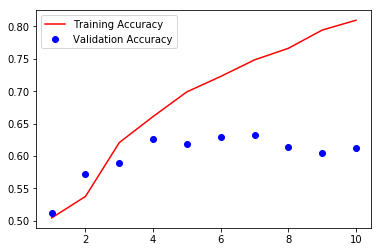

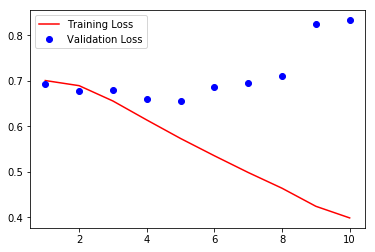

In [40]:
create_plots(history.history)

## Create Model With Our Own Embedding

In [41]:
model = Sequential()
model.add(Embedding(max_words, 100, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [42]:
compile()
history = fit()

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 8s 500us/step - loss: 0.4401 - acc: 0.7845 - val_loss: 0.3197 - val_acc: 0.8614
Epoch 2/10
15000/15000 [==============================] - 7s 450us/step - loss: 0.1142 - acc: 0.9606 - val_loss: 0.3783 - val_acc: 0.8489
Epoch 3/10
15000/15000 [==============================] - 7s 447us/step - loss: 0.0111 - acc: 0.9973 - val_loss: 0.5375 - val_acc: 0.8437
Epoch 4/10
15000/15000 [==============================] - 7s 451us/step - loss: 8.1056e-04 - acc: 0.9998 - val_loss: 0.7259 - val_acc: 0.8418
Epoch 5/10
15000/15000 [==============================] - 7s 449us/step - loss: 4.1166e-04 - acc: 0.9999 - val_loss: 0.8246 - val_acc: 0.8418
Epoch 6/10
15000/15000 [==============================] - 7s 446us/step - loss: 6.7929e-06 - acc: 1.0000 - val_loss: 0.9098 - val_acc: 0.8349
Epoch 7/10
15000/15000 [==============================] - 7s 449us/step - loss: 1.2896e-07 - acc: 1.0000 - val

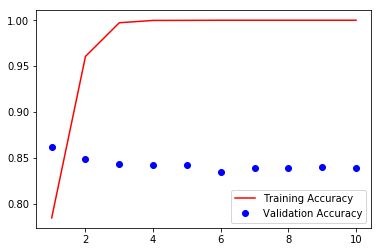

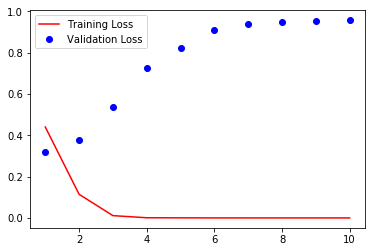

In [43]:
create_plots(history.history)

With about 85 % accuracy, it looks like we are better off creating our own embedded words, but the overfitting is terrible.

## Create Model With Dropout

In [44]:
model = Sequential()
model.add(Embedding(max_words, 100, input_length=maxlen))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [45]:
compile()
history = fit()

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 6s 419us/step - loss: 0.5849 - acc: 0.6712 - val_loss: 0.3876 - val_acc: 0.8210
Epoch 2/10
15000/15000 [==============================] - 6s 386us/step - loss: 0.3059 - acc: 0.8893 - val_loss: 0.3337 - val_acc: 0.8590
Epoch 3/10
15000/15000 [==============================] - 6s 385us/step - loss: 0.1396 - acc: 0.9583 - val_loss: 0.4608 - val_acc: 0.8611
Epoch 4/10
15000/15000 [==============================] - 6s 382us/step - loss: 0.0598 - acc: 0.9839 - val_loss: 0.6962 - val_acc: 0.8588
Epoch 5/10
15000/15000 [==============================] - 6s 382us/step - loss: 0.0295 - acc: 0.9924 - val_loss: 1.0252 - val_acc: 0.8513
Epoch 6/10
15000/15000 [==============================] - 6s 385us/step - loss: 0.0177 - acc: 0.9952 - val_loss: 1.2432 - val_acc: 0.8472
Epoch 7/10
15000/15000 [==============================] - 6s 383us/step - loss: 0.0164 - acc: 0.9951 - val_loss: 1.4604 - 

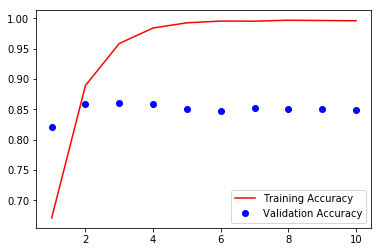

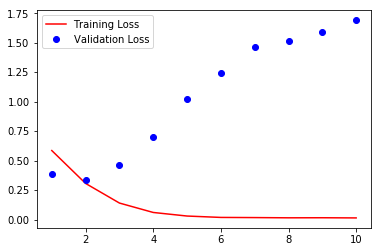

In [46]:
create_plots(history.history)

With Dropout and decreasing the hidden unit size, we are able to bump accuracy up to 85% but overfitting is still terrible.

## Simple RNN

In [47]:
from keras.layers import SimpleRNN
model = Sequential()
model.add(Embedding(max_words, 100, input_length=maxlen))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

In [48]:
compile()

In [49]:
history = fit()

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 23s 2ms/step - loss: 0.5558 - acc: 0.6966 - val_loss: 0.4313 - val_acc: 0.8114
Epoch 2/10
15000/15000 [==============================] - 23s 2ms/step - loss: 0.3261 - acc: 0.8663 - val_loss: 0.4724 - val_acc: 0.7918
Epoch 3/10
15000/15000 [==============================] - 22s 1ms/step - loss: 0.1910 - acc: 0.9274 - val_loss: 0.4273 - val_acc: 0.8386
Epoch 4/10
15000/15000 [==============================] - 22s 1ms/step - loss: 0.0948 - acc: 0.9683 - val_loss: 0.5269 - val_acc: 0.8036
Epoch 5/10
15000/15000 [==============================] - 22s 1ms/step - loss: 0.0459 - acc: 0.9854 - val_loss: 0.6633 - val_acc: 0.7757
Epoch 6/10
15000/15000 [==============================] - 22s 1ms/step - loss: 0.0248 - acc: 0.9923 - val_loss: 0.8175 - val_acc: 0.7486
Epoch 7/10
15000/15000 [==============================] - 23s 2ms/step - loss: 0.0115 - acc: 0.9966 - val_loss: 0.8072 - val_acc

In [51]:
x_train.shape

(15000, 150)